In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import os

In [7]:
def _get_metrics_from_tensorboard(event_acc, scalar):
    train_metrics, val_metrics = event_acc.Scalars(f'{scalar}/train'), event_acc.Scalars(f'{scalar}/valid')
    train_df, val_df = pd.DataFrame(train_metrics), pd.DataFrame(val_metrics)

    train_df.drop(columns=['wall_time'], inplace=True)
    val_df.drop(columns=['wall_time'], inplace=True)

    train_df.rename(columns={'value': f'train_{scalar}'}, inplace=True)
    val_df.rename(columns={'value': f'val_{scalar}'}, inplace=True)
    results = pd.merge(train_df, val_df, on='step', how='outer')
    results = results.dropna()
    results = results.drop(columns=['step'])
    return results


def tensorboard_results(log_dir, experiment_name):
    events = EventAccumulator(log_dir)
    events.Reload()

    print(events)
    loss, acc, prec, rec = (
        _get_metrics_from_tensorboard(events, 'loss_e'),
        _get_metrics_from_tensorboard(events, 'acc'),
        _get_metrics_from_tensorboard(events, 'prec'),
        _get_metrics_from_tensorboard(events, 'rec')
    )

    result_keys = {
        'BCE Loss': loss,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec
    }

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    fig.suptitle(f'Loss, Accuracy, Precision, Recall for {experiment_name}', fontsize=16)



    results_matrix = pd.concat([loss, acc, prec, rec], axis=1)
    for i, (key, value) in enumerate(result_keys.items()):
        fig_ = sns.lineplot(value, ax=axes[i])
        fig_.set(xlabel='Epoch', ylabel=key, title=key)
    return results_matrix

def top_metrics(results):
    metric_container = []
    for experiment_name, df in results.items():
        metric_container.append(_best_metrics(df, experiment_name))
    
    return pd.DataFrame(metric_container)

def _best_metrics(df, name):

    # last row from columns
    return {
        
        'Experiment': name,
        'BCE Loss': df['val_loss_e'].iloc[-1].round(4),
        'Accuracy': df['val_acc'].iloc[-1].round(4),
        'Precision': df['val_prec'].iloc[-1].round(4),
        'Recall': df['val_rec'].iloc[-1].round(4),
    }


In [2]:
seq_1_001 = 's3://dissertation-data-dmiller/lstm_experiments/results/data_v1/n_files_30/ordinal/sequence_length_1/data_partition_None/2023_05_03_11_10/version_0'
seq_10_001 = 's3://dissertation-data-dmiller/lstm_experiments/results/data_v1/n_files_30/ordinal/sequence_length_10/data_partition_None/2023_04_28_19_18/version_0/'
seq_20_001 = 's3://dissertation-data-dmiller/lstm_experiments/results/data_v1/n_files_30/ordinal/sequence_length_20/data_partition_None/2023_04_28_23_06/version_0'
seq_30_001 = 's3://dissertation-data-dmiller/lstm_experiments/results/data_v1/n_files_30/ordinal/sequence_length_30/data_partition_None/2023_04_30_15_57/version_0'
seq_40_001 = 's3://dissertation-data-dmiller/lstm_experiments/results/data_v1/n_files_30/ordinal/sequence_length_40/data_partition_None/2023_05_01_07_09/version_0'
seq_30_heuristic = 's3://dissertation-data-dmiller/lstm_experiments/results/data_v1/n_files_30/ordinal_heuristic/sequence_length_30/data_partition_None/2023_05_09_16_15/version_0'
embedding_30 ='s3://dissertation-data-dmiller/lstm_experiments/results/data_v1/n_files_30/embedded_ordinal/sequence_length_30/data_partition_None/2023_05_10_07_25/version_0'

seq_container = {}

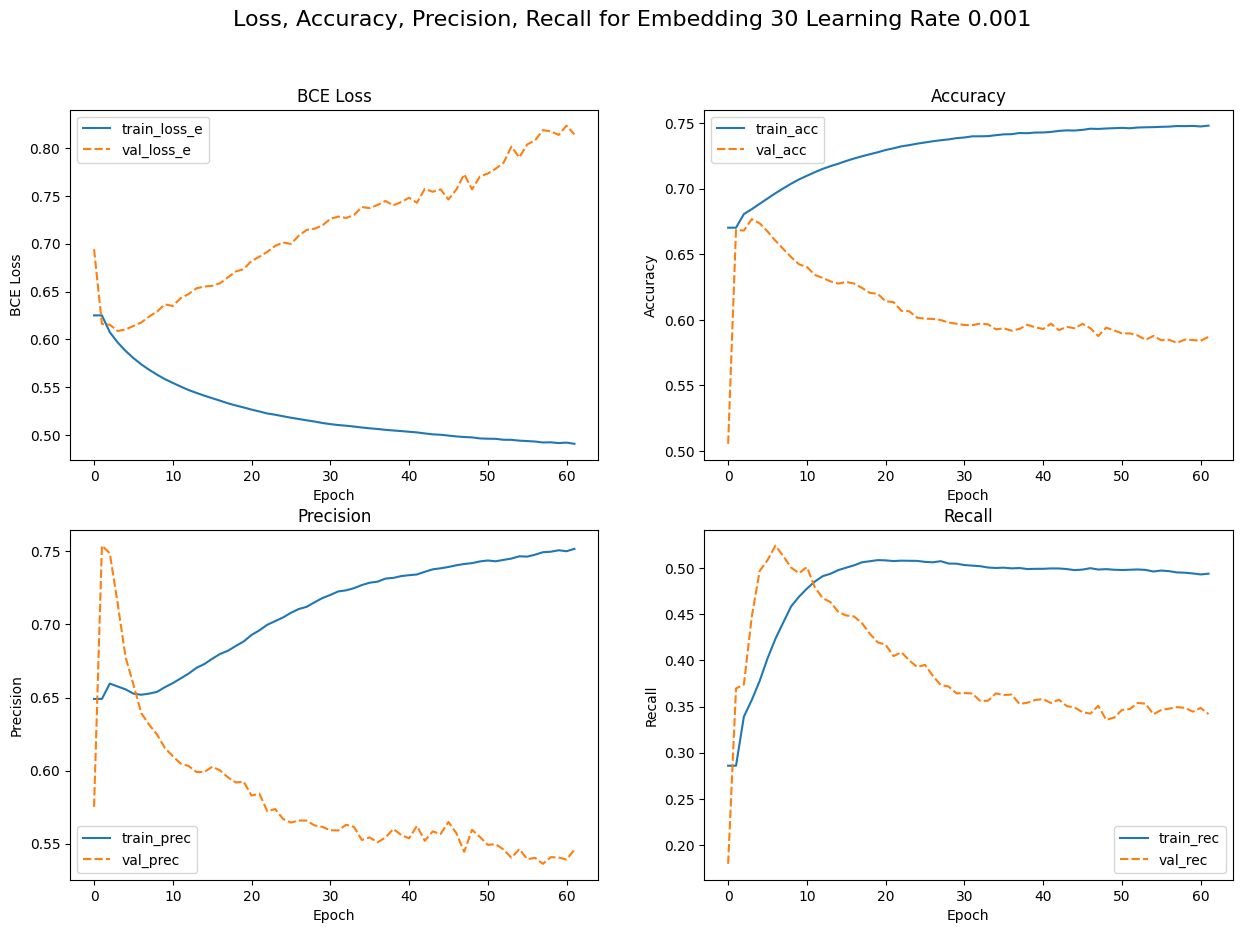

In [6]:
seq_container['EMBED 30'] = tensorboard_results(embedding_30, 'Embedding 30 Learning Rate 0.001')

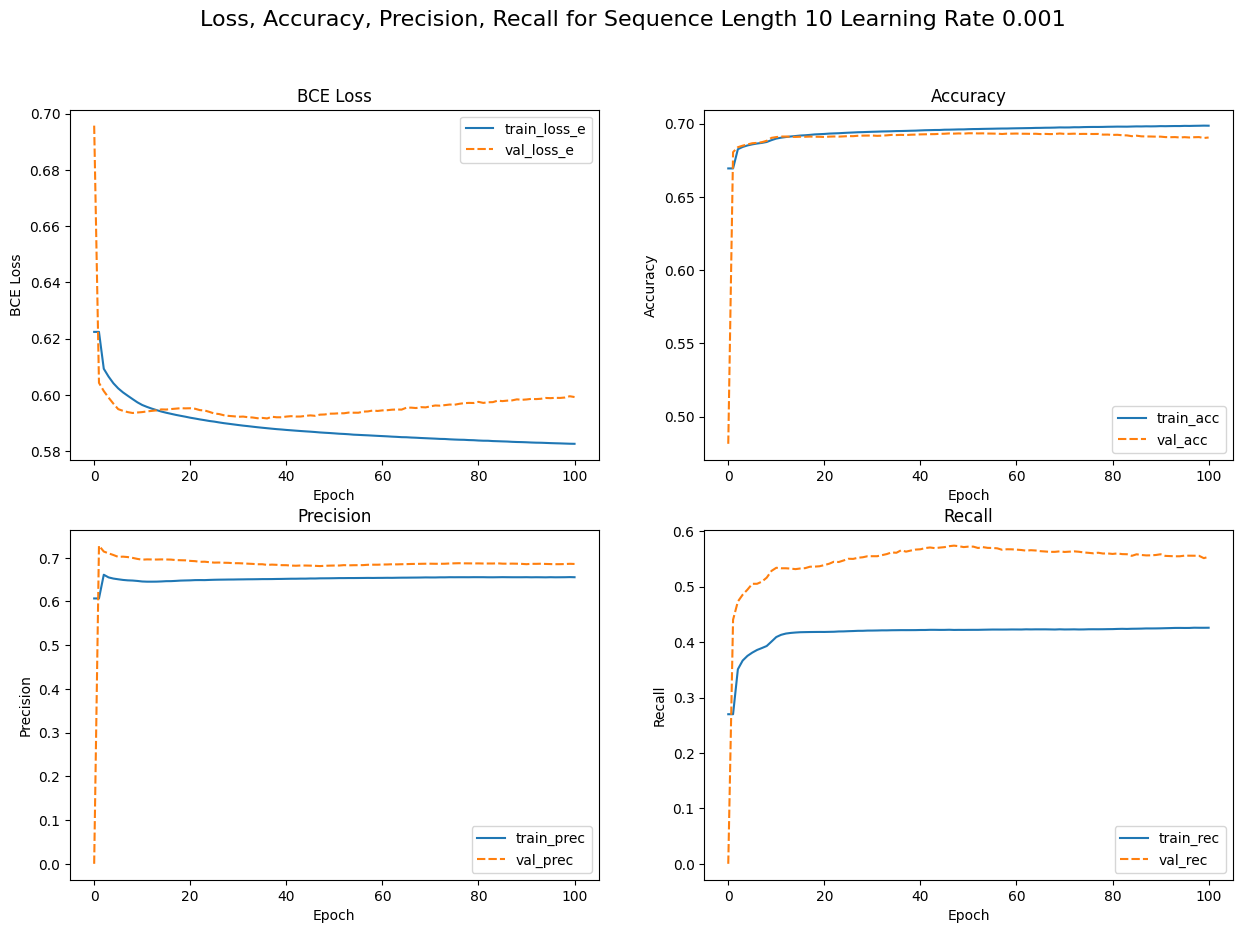

In [5]:
seq_container["SEQ 1 LR 001"] = tensorboard_results(seq_1_001, 'Sequence Length 10 Learning Rate 0.001')


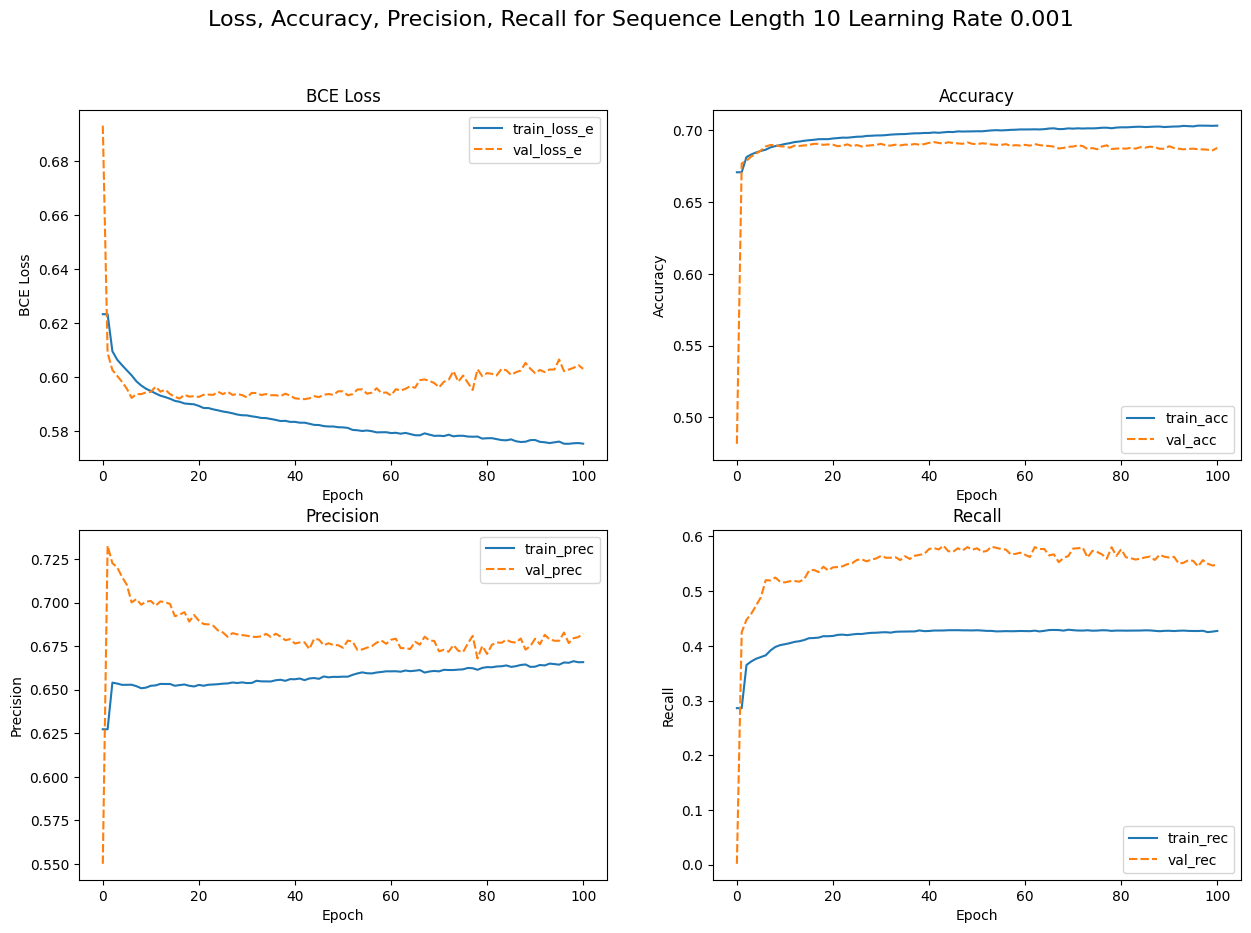

In [5]:
seq_container['SEQ 10 LR 001'] = tensorboard_results(seq_10_001, 'Sequence Length 10 Learning Rate 0.001')


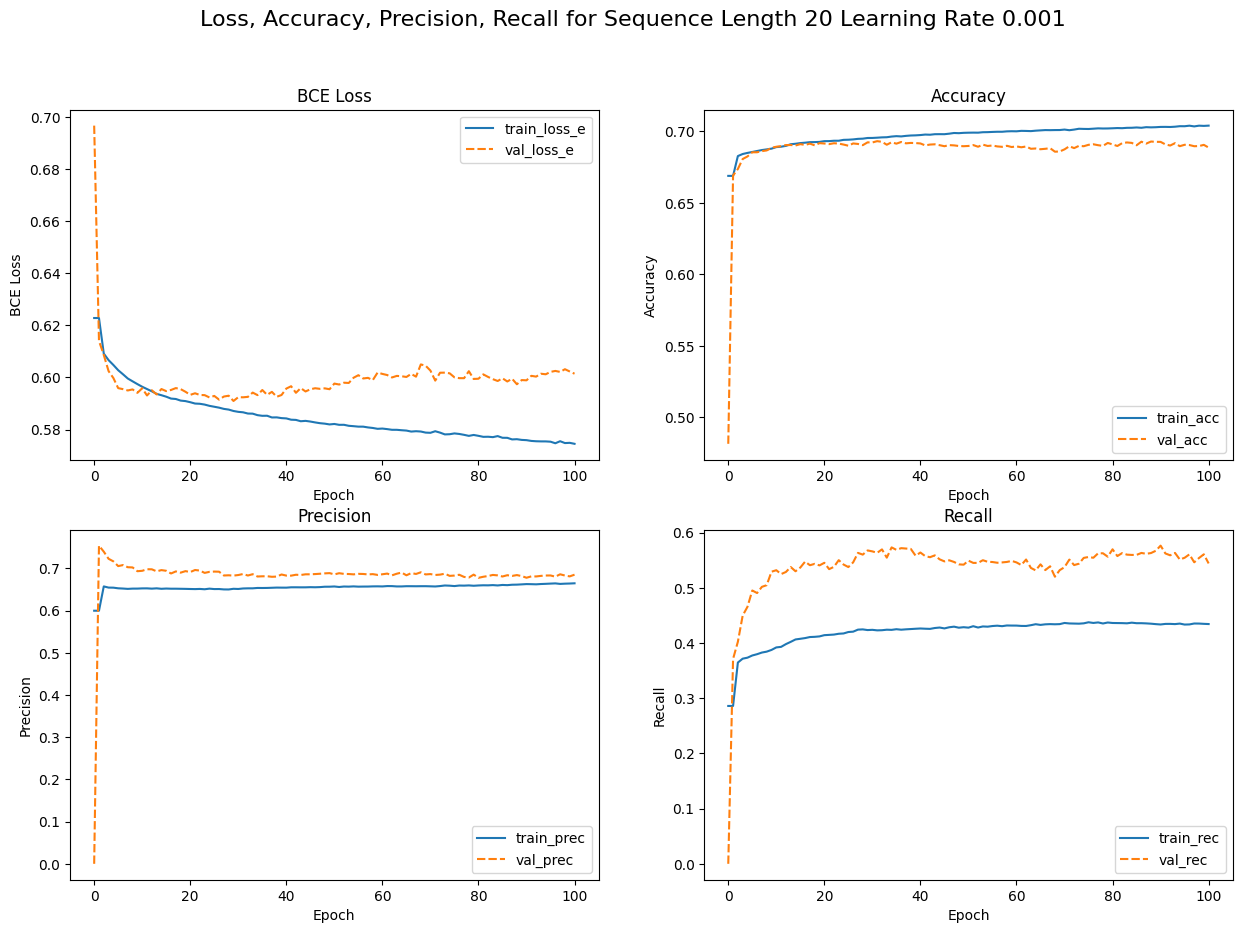

In [7]:
seq_container['SEQ 20 LR 001']= tensorboard_results(seq_20_001, 'Sequence Length 20 Learning Rate 0.001')


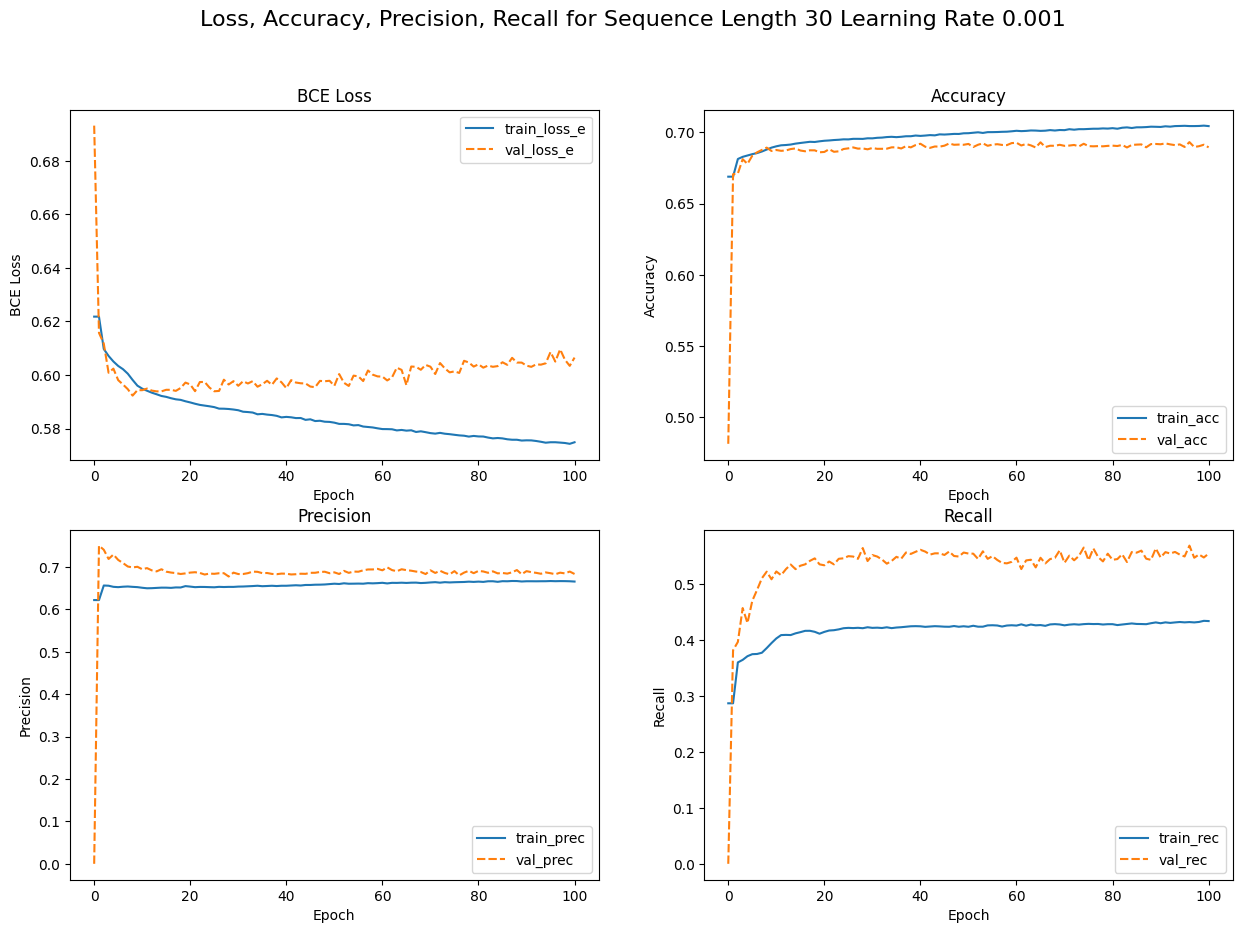

In [9]:
seq_container['SEQ 30 LR 001'] = tensorboard_results(seq_30_001, 'Sequence Length 30 Learning Rate 0.001')

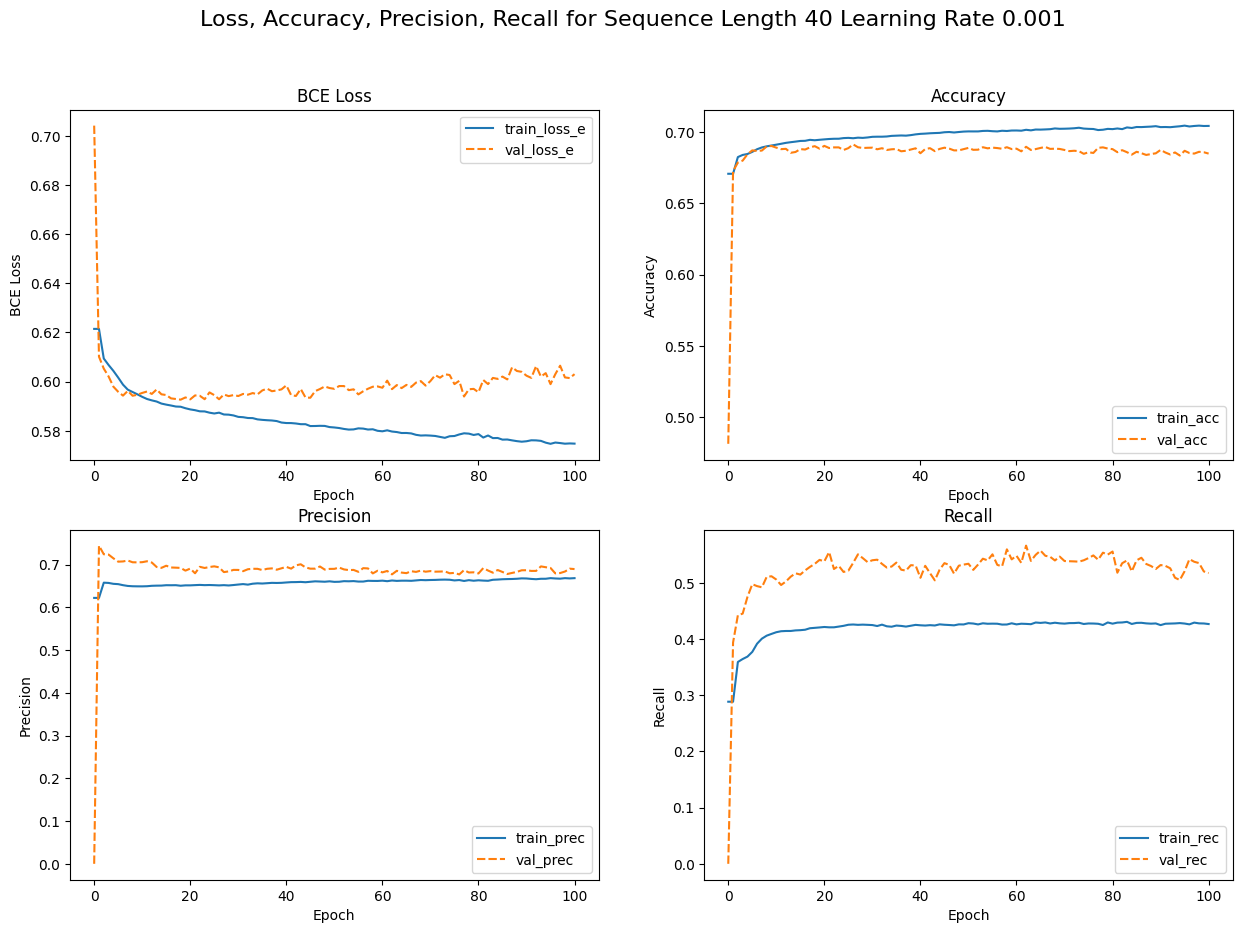

In [11]:
seq_container['SEQ 40 001'] = tensorboard_results(seq_40_001, 'Sequence Length 40 Learning Rate 0.001')

In [13]:
metric = top_metrics(seq_container)




In [16]:
metric

,Experiment,BCE Loss,Accuracy,Precision,Recall
0,SEQ 1 LR 001,0.5992,0.6905,0.6858,0.5538
1,SEQ 10 LR 001,0.6029,0.6877,0.6822,0.5482
2,SEQ 10 LR 01,0.5951,0.6867,0.7078,0.4952
3,SEQ 20 LR 001,0.6014,0.6886,0.6852,0.5441
4,SEQ 20 LR 01,0.5935,0.6940,0.6762,0.5898
5,SEQ 30 LR 001,0.6065,0.6895,0.6834,0.5547
6,SEQ 30 LR 01,0.5983,0.6847,0.7046,0.4924
7,SEQ 40 001,0.6030,0.6847,0.6896,0.5175
8,SEQ 40 LR 01,0.6030,0.6847,0.6896,0.5175


In [15]:
metric.to_csv('experiment_standard_performance_summary.csv', index=False)